In [1]:
from helpers.utilities import *
%run helpers/notebook_setup.ipynb

In [85]:
%R source('plots/colors.R');

In [3]:
__inputs__ = create_paths(
    path='data/integration/',
    csv=[
        'rna', 'rna_shared', 'protein', 'protein_shared',
        'patients_with_both', 'genes_in_both', 'patient_annotations_ordered'
    ]
)
clinical_path = 'data/clean/clinical/data_with_derived_variables.csv'

In [4]:
load_inputs(
    globals(), silent=True,
    loaders={'patients_with_both': Series.from_csv, 'genes_in_both': Series.from_csv},
)

In [5]:
cm_and_tmd = patients_with_both[patients_with_both.str.contains('TMD|CM')]

In [6]:
ra = rna.loc[:, cm_and_tmd].T
pa = protein.loc[:, cm_and_tmd].T

In [7]:
rs = rna.loc[:, cm_and_tmd].T
ps = protein.loc[:, cm_and_tmd].T

In [8]:
from sklearn.model_selection import train_test_split, cross_validate
X_train, X_test, Y_train, Y_test = train_test_split(ra, pa, random_state=0)

In [9]:
import rpy2.rinterface

def print_to_notebook(x):
    print(x, end='')

consolewrite_print_backup = rpy2.rinterface_lib.callbacks.consolewrite_print
rpy2.rinterface_lib.callbacks.consolewrite_print = print_to_notebook

consolewrite_warnerror_backup = rpy2.rinterface_lib.callbacks.consolewrite_warnerror
rpy2.rinterface_lib.callbacks.consolewrite_warnerror = print_to_notebook

### OmicsPLS - promising, but slow

In [10]:
%%R
library(OmicsPLS)


Attaching package: ‘OmicsPLS’

The following object is masked from ‘package:stats’:

    loadings



In [11]:
%%R -i rs -i ps
#save.image(file='opls.RData')

NULL


There is no automatic centering in OmicsPLS package, thus I will use scale function:

In [18]:
%%R
center = function(x) {
    scale(x, scale=F)
}

In [20]:
%R centered = as.data.frame(center(rs))
%R -o centered

In [21]:
assert np.isclose(centered.mean(), 0).all()
centered.mean()

TSPAN6            -1.268826e-16
DPM1               1.903239e-16
SCYL3             -4.229421e-16
C1orf112          -1.691768e-16
FGR               -8.458842e-17
                       ...     
SSU72P3            1.057355e-17
ENSG00000284552    0.000000e+00
AL022318.4         3.172066e-17
AC099654.14        0.000000e+00
AC093390.2         6.344132e-17
Length: 34502, dtype: float64

OmicsPLS package:
 - o2m_stripped - minimal opls for CV
 - o2m - for analysis
 - crossval_o2m - minimizes the sum of the prediction errors of X and 
 - crossval_o2m_adjR2 - alternative, proposed by authors, objective: maximize R^2 between T and U.
 
NIPALS is referred to as "alternative" or "power" method; to use it one should set p_thresh=1 (so that it is lower than number of features in X) or do an analogous thing with q_thresh. I will use NIPALS as it is much faster implementation (7min vs 1s)

In [40]:
%%time
%%R
res = o2m(center(rs), center(ps), 2, 2, 2)

CPU times: user 7min 50s, sys: 1.38 s, total: 7min 51s
Wall time: 7min 52s


Using NIPALS:

In [22]:
%%time
%%R
res = o2m(center(rs), center(ps), 2, 2, 2, p_thresh=1)

Using high dimensional mode with tolerance 1e-10 and max iterations 100
Power Method (comp 1) stopped after 17 iterations.

Power Method (comp 2) stopped after 45 iterations.

Power Method (comp 3) stopped after 25 iterations.

Power Method (comp 4) stopped after 44 iterations.

Power Method (comp 1) stopped after 18 iterations.

Power Method (comp 2) stopped after 39 iterations.

CPU times: user 1.1 s, sys: 11.2 ms, total: 1.11 s
Wall time: 1.61 s


There are two CV implementations, the standard one (minimizes the sum of the prediction errors of X and Y, where the prediction error is measured as RMSE):

In [23]:
%%R
getAnywhere(rmsep_combi)

A single object matching ‘rmsep_combi’ was found
It was found in the following places
  package:OmicsPLS
  namespace:OmicsPLS
with value

function (Xtst, Ytst, fit) 
{
    if (!inherits(fit, "o2m")) 
        stop("fit should be an O2PLS fit")
    if (!is.matrix(Xtst)) 
        Xtst <- t(Xtst)
    if (!is.matrix(Ytst)) 
        Ytst <- t(Ytst)
    input_checker(Xtst, Ytst)
    Yhat <- (Xtst - Xtst %*% fit$W_Yosc %*% t(fit$W_Yosc)) %*% 
        fit$W. %*% fit$B_T %*% t(fit$C.)
    Xhat <- (Ytst - Ytst %*% fit$C_Xosc %*% t(fit$C_Xosc)) %*% 
        fit$C. %*% fit$B_U %*% t(fit$W.)
    return(sqrt(mse(Yhat, Ytst)) + sqrt(mse(Xhat, Xtst)))
}
<bytecode: 0x559e81eb7e60>
<environment: namespace:OmicsPLS>


In [24]:
%%R
cv_res = crossval_o2m(
    center(rs), center(ps),
    1:3, # joint components to consider
    0:3, # X-specific components to consider
    0:3, # Y-specific components to consider
    nr_folds=2,
    nr_cores=6,
    p_thresh=1
)
cv_res

*******************
Elapsed time: 29.73 sec
*******
Minimal 2-CV error is at ax=3 ay=3 a=1 
*******
Minimum is 2.175566 
*******************


And slightly faster, R^2 based one (maximizes R^2 between T and U):

In [25]:
%%R
cv_res = crossval_o2m_adjR2(
    center(rs), center(ps),
    1:3, # joint components to consider
    0:3, # X-specific components to consider
    0:3, # Y-specific components to consider
    nr_folds=2,
    nr_cores=6,
    p_thresh=1
)
cv_res

minimum is at n = 2 
Elapsed time: 30.42 sec
       MSE n nx ny
1 2.269444 1  0  1
2 2.240067 2  3  1
3 2.272616 3  2  0


## B) Early integration by profiles (OPLS: TMD & CM, observations=patients)

### 1. When using all RNA & Proteins there are less than two predictive components (as for PLS)

In [26]:
%R -i ra -i pa

In [175]:
%%R
cv_res = crossval_o2m(
    center(ra), center(pa),
    1:5, # joint components to consider
    0:5, # X-specific components to consider
    0:5, # Y-specific components to consider
    nr_folds=3,
    nr_cores=7,
    p_thresh=1
)
cv_res

*******************
Elapsed time: 338.83 sec
*******
Minimal 3-CV error is at ax=4 ay=2 a=1 
*******
Minimum is 2.19102 
*******************


In [172]:
%%R
cv_res = crossval_o2m_adjR2(
    center(ra), center(pa),
    1:5, # joint components to consider
    0:5, # X-specific components to consider
    0:5, # Y-specific components to consider
    nr_folds=3,
    nr_cores=6,
    p_thresh=1
)
cv_res

minimum is at n = 1 
Elapsed time: 151.36 sec
       MSE n nx ny
1 2.228734 1  0  1
2 2.260158 2  3  1
3 2.242791 3  2  0
4 2.269277 4  2  2
5 2.340920 5  0  4


In [180]:
%%R
fit_all = o2m(center(ra), center(pa), n=1, nx=4, ny=1, p_thresh=1)

Using high dimensional mode with tolerance 1e-10 and max iterations 100
Power Method (comp 1) stopped after 17 iterations.

Power Method (comp 2) stopped after 45 iterations.

Power Method (comp 3) stopped after 25 iterations.

Power Method (comp 4) stopped after 44 iterations.

Power Method (comp 5) stopped after 50 iterations.

Power Method (comp 1) stopped after 24 iterations.



In [181]:
%%R
summary(fit_all)


*** Summary of the O2PLS fit *** 

-  Call: o2m(X = center(ra), Y = center(pa), n = 1, nx = 4, ny = 1, p_thresh = 1) 

-  Modeled variation
-- Total variation:
in X: 1420335 
in Y: 17842.19 

-- Joint, Orthogonal and Noise as proportions:

           data X data Y
Joint       0.086  0.235
Orthogonal  0.199  0.039
Noise       0.715  0.727

-- Predictable variation in Y-joint part by X-joint part:
Variation in T*B_T relative to U: 0.721 
-- Predictable variation in X-joint part by Y-joint part:
Variation in U*B_U relative to T: 0.721 

-- Variances per component:

            Comp 1
X joint 122402.288
Y joint   4190.048

         Comp 1   Comp 2   Comp 3   Comp 4
X Orth 146111.2 104797.2 85170.16 66693.93

         Comp 1
Y Orth 1639.802


-  Coefficient in 'U = T B_T + H_U' model:
-- Diagonal elements of B_T =
 0.157 



**TODO: Use mean-variance trend corrected RNA data and check the orthogonal variation**

In [30]:
%%R
names(fit_all)

 [1] "Tt"      "W."      "U"       "C."      "E"       "Ff"      "T_Yosc" 
 [8] "P_Yosc." "W_Yosc"  "U_Xosc"  "P_Xosc." "C_Xosc"  "B_U"     "B_T."   
[15] "H_TU"    "H_UT"    "X_hat"   "Y_hat"   "R2X"     "R2Y"     "R2Xcorr"
[22] "R2Ycorr" "R2X_YO"  "R2Y_XO"  "R2Xhat"  "R2Yhat"  "flags"  


In [182]:
%%R
import::here(plot_most_extreme_loadings, matrix_scores_plot, single_scores_bar, .from='plots/omics_o2pls.R')

TODO: color-code?
 - RNA = yellow
 - protein = pink

In [183]:
patients_union = list(rna.columns | protein.columns) 
clinical = read_csv(clinical_path, index_col=0).loc[patients_union]

In [184]:
meningitis = clinical.loc[ra.index].Meningitis

In [185]:
%R -i meningitis

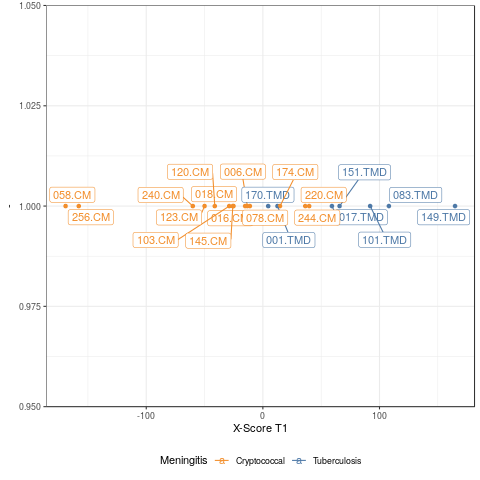

In [186]:
%%R
matrix_scores_plot(fit_all, 'X', color=meningitis) + color_meningitis + nice_theme

Because there is only one predictive component, the loadings reduce to one dimensional plot.

To spread the values meaningfully I used the mean abundance levels as x axis.

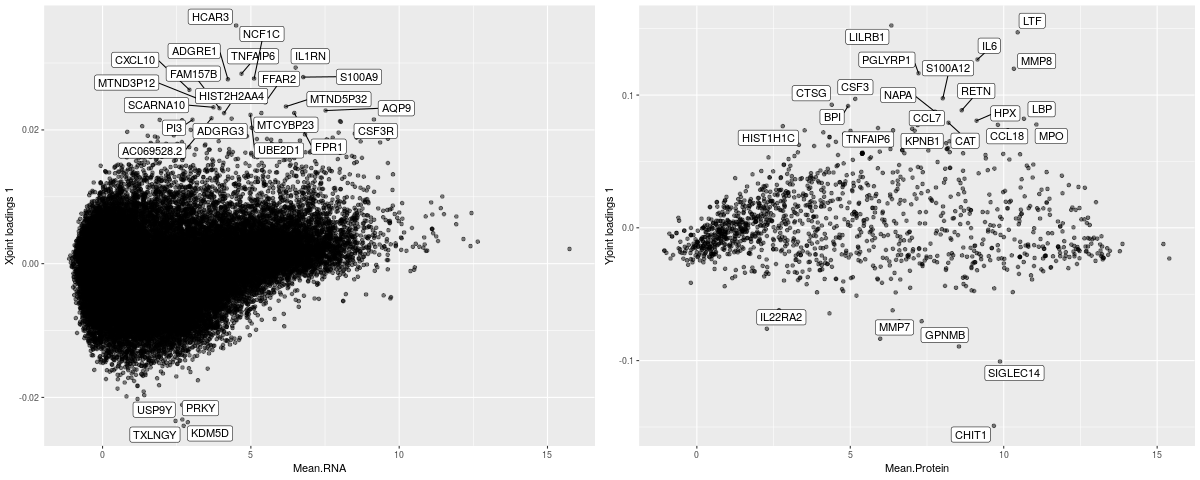

In [187]:
%%R -w 1200
gridExtra::grid.arrange(
    plot_most_extreme_loadings(fit_all, x_values=colMeans(ra), x_axis='Mean.RNA', loading_name='Xjoint'),
    plot_most_extreme_loadings(fit_all, x_values=colMeans(pa), x_axis='Mean.Protein', loading_name='Yjoint'),
    ncol=2
)

And with scores ('bi-plot'):

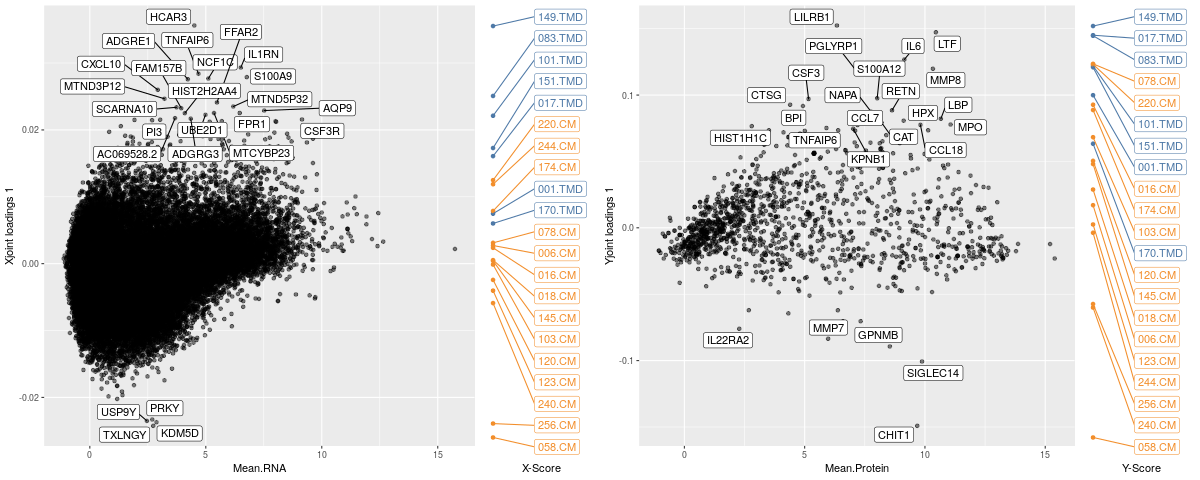

In [188]:
%%R -w 1200
gridExtra::grid.arrange(
    plot_most_extreme_loadings(fit_all, x_values=colMeans(ra), x_axis='Mean.RNA', loading_name='Xjoint'),
    single_scores_bar(fit_all, 'X', color=meningitis) + color_meningitis,
    plot_most_extreme_loadings(fit_all, x_values=colMeans(pa), x_axis='Mean.Protein', loading_name='Yjoint'),
    single_scores_bar(fit_all, 'Y', color=meningitis) + color_meningitis,
    ncol=4,
    widths=c(0.4, 0.1, 0.4, 0.1)
)

**TODO: I could also colour the values according to differential expression status in each of the datasets, using a diverging scale.**

Remainder: KPNB1 - highlighted in correlations analysis

Scores:

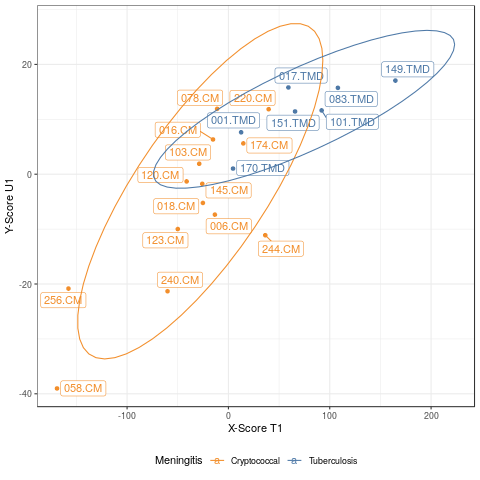

In [189]:
%%R
scores_plot = function(fit, t=1, u=1, color='black') {
    data = data.frame(t=fit$Tt[,t], u=fit$U[,u], label=rownames(fit$U), color=color)
    (
        ggplot(data, aes(x=t, y=u, label=label, color=color))
        + geom_point()
        + ggrepel::geom_label_repel()
        + xlab(paste0('X-Score T', t))
        + ylab(paste0('Y-Score U', u))
        + stat_ellipse()
    )
}
scores_plot(fit_all, color=meningitis) + color_meningitis + nice_theme

Structured noise:

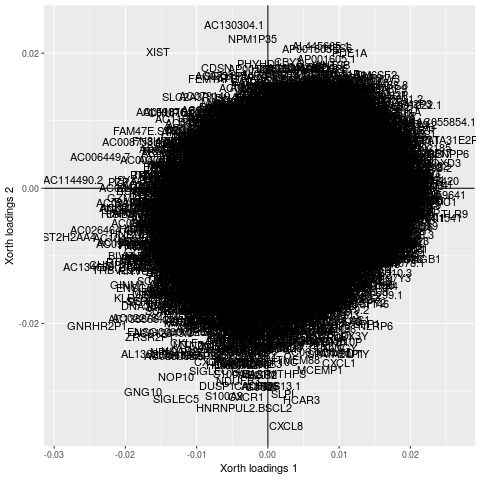

In [190]:
%%R
plot(fit_all, label='colnames', loading_name='Xorth', j=2)

If we enforce additional y-orth component:

In [195]:
%%R
fit_all_y2 = o2m(center(ra), center(pa), n=1, nx=4, ny=2, p_thresh=1)

Using high dimensional mode with tolerance 1e-10 and max iterations 100
Power Method (comp 1) stopped after 17 iterations.

Power Method (comp 2) stopped after 45 iterations.

Power Method (comp 3) stopped after 25 iterations.

Power Method (comp 4) stopped after 44 iterations.

Power Method (comp 5) stopped after 50 iterations.

Power Method (comp 1) stopped after 21 iterations.



In [216]:
%%R
summary(fit_all_y2)


*** Summary of the O2PLS fit *** 

-  Call: o2m(X = center(ra), Y = center(pa), n = 1, nx = 4, ny = 2, p_thresh = 1) 

-  Modeled variation
-- Total variation:
in X: 1420335 
in Y: 17842.19 

-- Joint, Orthogonal and Noise as proportions:

           data X data Y
Joint       0.085  0.241
Orthogonal  0.199  0.086
Noise       0.716  0.672

-- Predictable variation in Y-joint part by X-joint part:
Variation in T*B_T relative to U: 0.717 
-- Predictable variation in X-joint part by Y-joint part:
Variation in U*B_U relative to T: 0.717 

-- Variances per component:

            Comp 1
X joint 121232.538
Y joint   4305.062

         Comp 1   Comp 2   Comp 3   Comp 4
X Orth 146111.2 104797.2 85170.16 66693.93

         Comp 1   Comp 2
Y Orth 1688.372 1311.634


-  Coefficient in 'U = T B_T + H_U' model:
-- Diagonal elements of B_T =
 0.16 



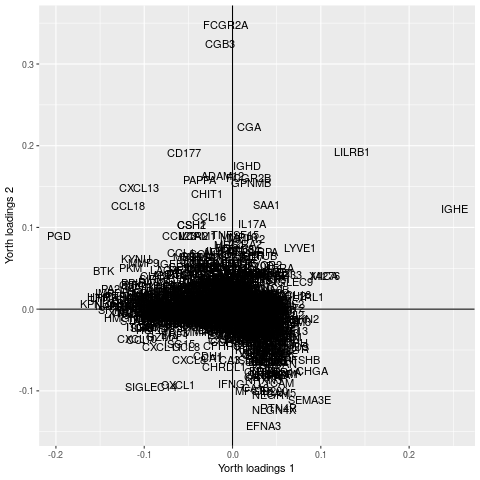

In [197]:
%%R
plot(fit_all_y2, label='colnames', loading_name='Yorth', j=2)

### 2. When adding all other TM

In [178]:
cm_and_tm = patients_with_both[patients_with_both.str.contains('TM|CM')]
ra_all_tm = rna.loc[:, cm_and_tm].T
pa_all_tm = protein.loc[:, cm_and_tm].T

In [200]:
%R -i ra_all_tm -i pa_all_tm

In [201]:
%%R
cv_res = crossval_o2m(
    center(ra_all_tm), center(pa_all_tm),
    1:5, # joint components to consider
    0:5, # X-specific components to consider
    0:5, # Y-specific components to consider
    nr_folds=3,
    nr_cores=7,
    p_thresh=1
)
cv_res

*******************
Elapsed time: 373.18 sec
*******
Minimal 3-CV error is at ax=4 ay=0 a=1 
*******
Minimum is 2.319394 
*******************


Slightly worse.

In [215]:
%%R
cv_res = crossval_o2m_adjR2(
    center(ra_all_tm), center(pa_all_tm),
    1:5, # joint components to consider
    0:5, # X-specific components to consider
    0:5, # Y-specific components to consider
    nr_folds=3,
    nr_cores=7,
    p_thresh=1
)
cv_res

minimum is at n = 1 
Elapsed time: 212.34 sec
       MSE n nx ny
1 2.411593 1  0  2
2 2.432081 2  0  2
3 2.451230 3  3  2
4 2.447711 4  4  0
5 2.429042 5  5  0


In [ ]:
meningitis_full = clinical.loc[ra_all_tm.index].Meningitis

### 3. When looking at the RNA shared with Proteins data

In [ ]:
%%R
cv_res = crossval_o2m(
    center(rs), center(ps),
    1:5, # joint components to consider
    0:5, # X-specific components to consider
    0:5, # Y-specific components to consider
    nr_folds=3,
    nr_cores=7,
    p_thresh=1
)
cv_res

## C) Early concatenation PLS-DA

In [204]:
from helpers.pls import concat_abundances

In [205]:
full_joined_rp = concat_abundances(rna=ra, protein=pa)
full_joined_rp.head(2)

,TSPAN6.R,DPM1.R,SCYL3.R,C1orf112.R,FGR.R,...,SERPINF1.P,CTSF.P,FTCD.P,USP25.P,PLXNB2.P
001.TMD,1.687826,-1.189430,4.956709,3.532492,6.941349,...,13.396705,6.172488,0.701885,1.291204,9.712462
006.CM,0.750583,2.436818,4.564363,-1.189430,6.874971,...,12.438645,6.207233,0.428609,1.374512,9.844042


In [213]:
meningitis

001.TMD    Tuberculosis
006.CM     Cryptococcal
016.CM     Cryptococcal
017.TMD    Tuberculosis
018.CM     Cryptococcal
               ...     
240.CM     Cryptococcal
244.CM     Cryptococcal
256.CM     Cryptococcal
174.CM     Cryptococcal
078.CM     Cryptococcal
Name: Meningitis, Length: 21, dtype: object

In [214]:
%%R
cv_res = crossval_o2m(
    center(full_joined_rp), as.factor(meningitis),
    1:1, # joint components to consider
    0:5, # X-specific components to consider
    0:1, # Y-specific components to consider
    nr_folds=3,
    nr_cores=7,
    p_thresh=0
)
cv_res

Error in crossval_o2m(center(full_joined_rp), as.factor(meningitis), 1:5,  : 
  ncol(Y) > max(a) + max(ay) is not TRUE
Calls: <Anonymous> ... <Anonymous> -> withVisible -> crossval_o2m -> stopifnot

Error in crossval_o2m(center(full_joined_rp), as.factor(meningitis), 1:5,  : 
  ncol(Y) > max(a) + max(ay) is not TRUE
Calls: <Anonymous> ... <Anonymous> -> withVisible -> crossval_o2m -> stopifnot


## Normalization

In [ ]:
raw_gene_path = 'data/clean/protein/gene_levels_by_entrez.csv'

In [ ]:
raw_gene_matrix = read_csv(raw_gene_path, index_col=0)

In [ ]:
%%R -i out_tmm_normalized_counts_path -i out_tmm_normalized_counts_gene_level_path -i out_rle_normalized_counts_gene_level_path -i raw_gene_matrix
import::here(normalize_abundance, .from='helpers/preprocessing.R')

normalize_abundance(raw_protein_matrix, by_condition, out_tmm_normalized_counts_path)
normalize_abundance(raw_gene_matrix,    by_condition, out_tmm_normalized_counts_gene_level_path)
normalize_abundance(raw_gene_matrix,    by_condition, out_rle_normalized_counts_gene_level_path, 'RLE')